# Example: projection

[Example Data] https://pan.baidu.com/s/1nwsIcDr <span style="color:gray">(pswd: s5re)</span>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
# %matplotlib inline

from __future__ import division, print_function
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import sunpy.map
from copy import deepcopy

path = %pwd
import sys
sys.path.append(path + '/../modules')
from usr_sunpy import *

print('Python version: %s' % sys.version.split('(')[0])
print('SunPy version: %s' % sunpy.__version__)

Python version: 3.6.5 |Anaconda, Inc.| 
SunPy version: 0.8.5


## Read data

In [2]:
fname1 = path + '/' + 'data/hmi.B_720s.20150827_052400_TAI.field.fits'
fname2 = path + '/' + 'data/hmi.B_720s.20150827_052400_TAI.inclination.fits'
fname3 = path + '/' + 'data/hmi.B_720s.20150827_052400_TAI.azimuth.fits'
fname4 = path + '/' + 'data/hmi.B_720s.20150827_052400_TAI.disambig.fits'
print('[Path] %s' % path)

[Path] /home/lydia/codes/zly/scripts-sunpy/plothmi


In [3]:
mapb = read_sdo(fname1)
mapi = read_sdo(fname2)
mapa = read_sdo(fname3)
mapd = read_sdo(fname4)

hmi.B_720s.20150827_052400_TAI.field.fits	[4096, 4096]
hmi.B_720s.20150827_052400_TAI.inclination.fits	[4096, 4096]
hmi.B_720s.20150827_052400_TAI.azimuth.fits	[4096, 4096]
hmi.B_720s.20150827_052400_TAI.disambig.fits	[4096, 4096]


In [4]:
# Disambiguate
mapa.data[mapd.data > 3] += 180.

In [5]:
mapbx = deepcopy(mapb)
mapby = deepcopy(mapb)
mapbz = deepcopy(mapb)
mapbx.data[:] = mapb.data * np.sin(np.deg2rad(mapi.data)) * np.cos(np.deg2rad(mapa.data + 270.))
mapby.data[:] = mapb.data * np.sin(np.deg2rad(mapi.data)) * np.sin(np.deg2rad(mapa.data + 270.))
mapbz.data[:] = mapb.data * np.cos(np.deg2rad(mapi.data))

In [6]:
# Rotate(CCW)
order = 1
print('Correcting image axes...')
mapbx = mapbx.rotate(order=order)
mapby = mapby.rotate(order=order)
mapbz = mapbz.rotate(order=order)
print('Rotation angle = %f deg (CCW)' % -mapb.meta['crota2'])

Correcting image axes...
Rotation angle = -180.013600 deg (CCW)


In [7]:
# Get the center ('crpix1', 'crpix2') - First pixel is number 1.
pcenter = ((mapbz.meta['crpix1'] - 1) * u.pix, (mapbz.meta['crpix2'] - 1) * u.pix)
center = mapbz.pixel_to_world(*pcenter)
print('[Image_center] (%.3f, %.3f) pixel = (%7.4f, %7.4f) arcsec  (lon, lat) = (%8.5f, %8.5f) deg' %
      ((mapbz.dimensions.x.value-1.)/2., (mapbz.dimensions.y.value-1.)/2.,
        mapbz.center.Tx.value, mapbz.center.Ty.value,
        mapbz.center.heliographic_stonyhurst.lon.value, mapbz.center.heliographic_stonyhurst.lat.value))
print('[ Disk_center] (%.3f, %.3f) pixel = (%7.4f, %7.4f) arcsec  (lon, lat) = (%8.5f, %8.5f) deg' %
      (pcenter[0].value, pcenter[1].value, center.Tx.value, center.Ty.value,
       center.heliographic_stonyhurst.lon.value, center.heliographic_stonyhurst.lat.value))
print('[ Observation] (lon, lat, radius) = (%g deg, %g deg, %g m)' %
      (mapbz.heliographic_longitude.value, mapbz.heliographic_latitude.value, mapbz.observer_coordinate.radius.value))

[Image_center] (2048.500, 2048.500) pixel = (-7.1497,  2.8244) arcsec  (lon, lat) = (-0.43292,  7.25845) deg
[ Disk_center] (2063.175, 2043.400) pixel = ( 0.0000,  0.0000) arcsec  (lon, lat) = ( 0.00000,  7.08900) deg
[ Observation] (lon, lat, radius) = (0 deg, 7.089 deg, 1.51197e+11 m)


## Submap

In [8]:
xmin, xmax = (500.,800.)  # arcsec
ymin, ymax = (-450.,-200.)

bl = SkyCoord(xmin*u.arcsec, ymin*u.arcsec, frame=mapbz.coordinate_frame)
tr = SkyCoord(xmax*u.arcsec, ymax*u.arcsec, frame=mapbz.coordinate_frame)
smapbx = mapbx.submap(bl, tr)
smapby = mapby.submap(bl, tr)
smapbz = mapbz.submap(bl, tr)
print('Submap: %s = %s arcsec' % (tuple(map(int, u.Quantity(smapbz.dimensions).value)), ((xmin, xmax), (ymin, ymax))))

Submap: (595, 495) = ((500.0, 800.0), (-450.0, -200.0)) arcsec


<IPython.core.display.Javascript object>


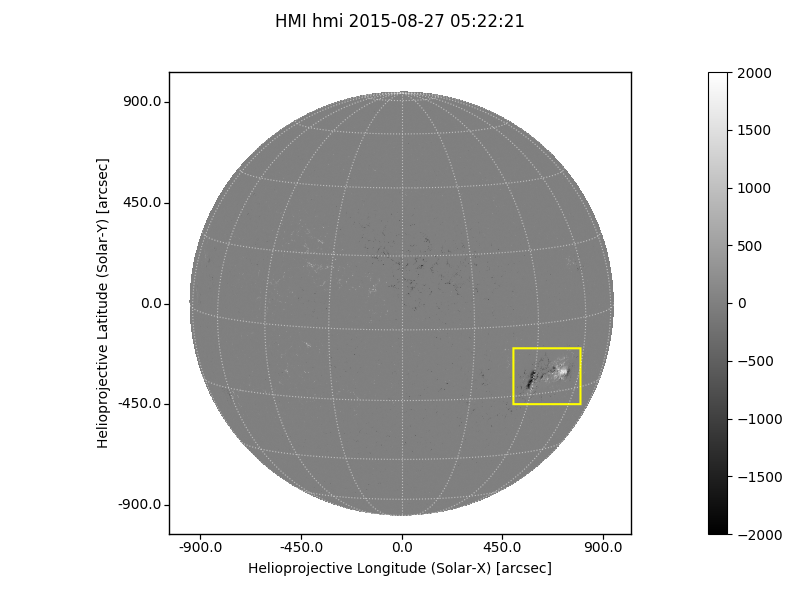

In [9]:
fig1 = plt.figure(figsize=(8, 6), dpi=100)
ax1 = fig1.add_subplot(111, projection=mapbz)
plot_map(ax1, mapbz)

# Properties
mapbz.draw_grid(axes=ax1, grid_spacing=20*u.deg, color='w', linestyle=':')
mapbz.draw_rectangle(bl, (xmax-xmin)*u.arcsec, (ymax-ymin)*u.arcsec, axes=ax1, color='yellow', linewidth=1.5)
# ax1.set_title(mapbz.latex_name, y=1.05);
plt.clim(-2000., 2000.)
# fig1.savefig(path+'/'+'example_proj_disk.png', dpi=200)

<IPython.core.display.Javascript object>


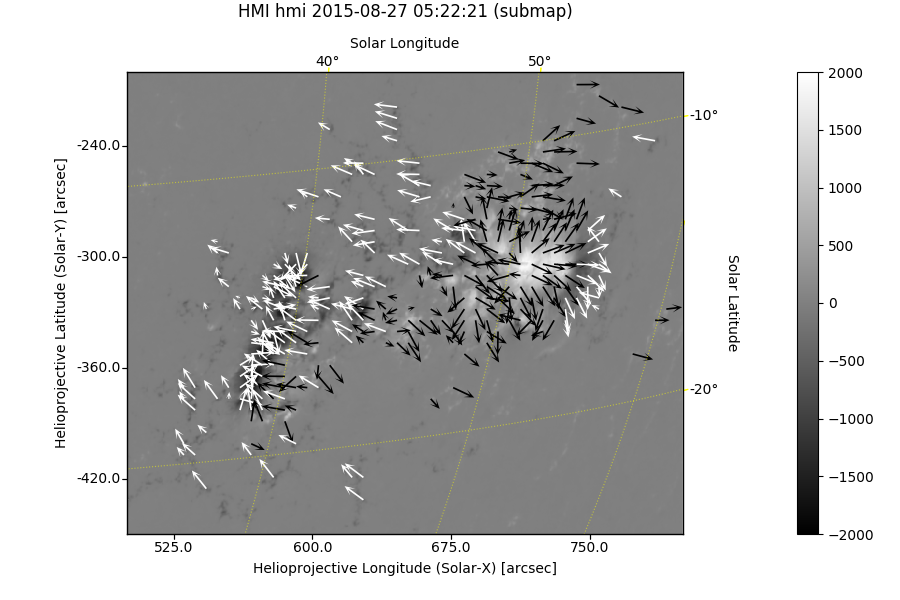

In [10]:
iskip, jskip = (12, 12)

fig2 = plt.figure(figsize=(9, 6), dpi=100)
ax2 = fig2.add_subplot(111, projection=smapbz)
im2 = plot_map(ax2, smapbz)
plot_vmap(ax2, smapbx, smapby, smapbz, iskip=iskip, jskip=jskip, cmin=100., vmax=500., cmap='binary',
          scale_units='xy', scale=1/0.05, minlength=0.02)

# Properties
smapbz.draw_grid(axes=ax2, grid_spacing=10*u.deg, color='yellow', linestyle=':')
ax2.set_title(mapbz.latex_name+' (submap)', y=1.1);
plt.subplots_adjust(right=0.8)  # Reduce the value to move the colorbar to the right
im2.set_clim(-2000., 2000.)

## Projection

In [11]:
hx, hy = image_to_helio(smapbz)
smapbx_h, smapby_h, smapbz_h = image_to_helio(smapbx, smapby, smapbz)

print('(xmin, xmax) = (%9.3f, %9.3f) arcsec\n(ymin, ymax) = (%9.3f, %9.3f) arcsec' %
      (hx.min(), hx.max(), hy.min(), hy.min()))

(xmin, xmax) = ( -252.233,   252.233) arcsec
(ymin, ymax) = ( -156.618,  -156.618) arcsec


<IPython.core.display.Javascript object>


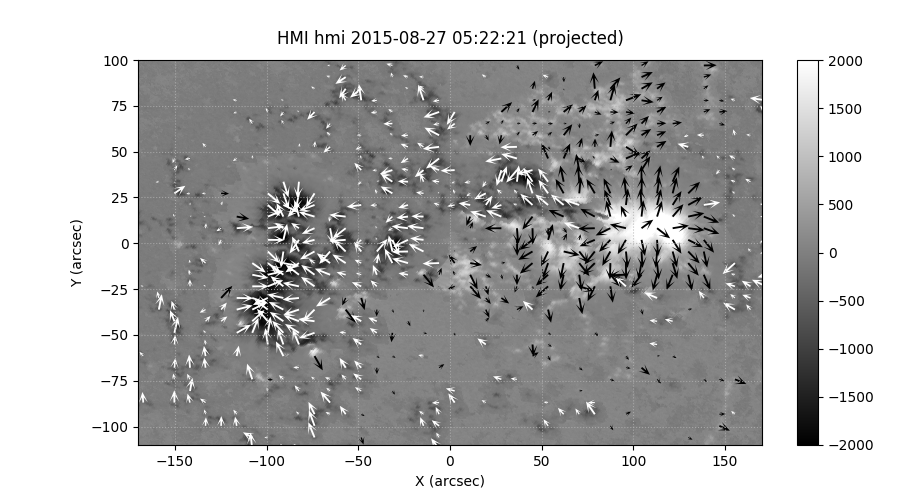

In [12]:
iskip, jskip = (10, 10)

fig3 = plt.figure(figsize=(9, 5), dpi=100)
ax3 = fig3.add_subplot(111)
im3 = plot_map(ax3, smapbz_h, hx, hy)
plot_vmap(ax3, smapbx_h, smapby_h, smapbz_h, hx, hy,
          iskip=iskip, jskip=jskip, cmin=100., vmax=300., cmap='binary',
          scale_units='xy', scale=1/0.03, minlength=0.05)

# Properties
ax3.grid(True, ls=':', alpha=0.8)
ax3.set_title(mapbz.latex_name+' (projected)', y=1.02);
plt.subplots_adjust(right=0.9)  # Reduce the value to move the colorbar to the right
ax3.set_xlim((-170,170))
ax3.set_ylim((-110,100))
im3.set_clim((-2000,2000))